# Определение перспективного тарифа для телеком компании

Компания «Мегалайн» — федеральный оператор сотовой связи.  
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. 
В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Содержание

- Описание данных
- Импорт библиотек и общая предустановка
- Общее изучение данных
- Подготовка данных
- Анализ данных
- Проверка гипотез
- Общий вывод

## Описание данных

__Таблица users (информация о пользователях)__
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

__Таблица calls (информация о звонках)__
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

__Таблица messages (информация о сообщениях)__
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

__Таблица internet (информация об интернет-сессиях)__
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

__Таблица tariffs (информация о тарифах)__
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

<font color='green'>Молодец, что в начале работы коротко описываешь наши данные и обрисовываешь цели. Хороший план - уже пол дела. В таком виде работа смотрится цельно и её смогу оценить не только я, но и посторонний человек, в том числе потенциальный работодатель.

## Импорт библиотек и глобальная предустановка

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# отключение предупреждений Anaconda
warnings.simplefilter('ignore')

# размер графиков по умолчанию
from pylab import rcParams
rcParams['figure.figsize'] = 9, 6

# цветовая палитра
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# отображение одного знака после запятой
pd.options.display.float_format = '{:,.1f}'.format

## 1. Общее изучение данных

In [2]:
# открытие файлов
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

___

In [3]:
# общая проверка состава датафреймов
df_temp = [[users, 'users'],
          [calls, 'calls'],
          [internet, 'internet'],
          [messages, 'messages'],
         [tariffs,'tariffs']
         ]

for df in df_temp:
    print('Проверка состава датафрейма', df[1])
    print()
    print(df[0].info())
    print('___________')
    print()
    print()

Проверка состава датафрейма users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
___________


Проверка состава датафрейма calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
___________


Проверка состава датафрейма internet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id  

Большинство датафреймов выгружены без пропусков данных. Пропуски в датафрейме __users__ в колонке __churn_date__ объясняются тем, что записи в принципе не заносятся пока клиент не сменил тариф.

___

In [4]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
115,1115,71,NaN,Москва,Рашид,Толкачев,2018-07-28,smart
221,1221,40,NaN,Белгород,Джемма,Сафонова,2018-06-03,smart
23,1023,42,NaN,Томск,Людмила,Мельникова,2018-10-22,smart
263,1263,32,NaN,Балашиха,Ермолай,Зайцев,2018-04-30,smart
295,1295,19,NaN,Краснодар,Олеся,Зимина,2018-09-19,smart


В датафрейме __users__ в столбцах __churn_date__, __reg_date__ требуется перевести даты в корректный тип данных.

In [5]:
calls.sample(5)

,id,call_date,duration,user_id
130830,1335_307,2018-08-25,13.7,1335
135514,1346_64,2018-11-28,2.2,1346
89282,1224_199,2018-06-04,0.0,1224
65524,1168_675,2018-11-25,0.0,1168
196670,1482_37,2018-11-02,0.0,1482


В столбцах __call_date__ требуется перевести даты в корректный тип данных.

In [6]:
internet.sample(5)

,id,mb_used,session_date,user_id
119393,1402_428,890.6,2018-07-17,1402
128099,1429_257,249.1,2018-05-31,1429
107919,1368_5,264.2,2018-12-15,1368
53499,1179_361,14.0,2018-08-15,1179
12975,1045_151,408.9,2018-08-07,1045


В столбцах __session_date__ требуется перевести даты в корректный тип данных.

In [7]:
messages.sample(5)

,id,message_date,user_id
31316,1137_6,2018-12-04,1137
70998,1300_750,2018-10-08,1300
100547,1411_383,2018-09-28,1411
69410,1296_152,2018-09-14,1296
96432,1396_83,2018-12-07,1396


В столбцах __message_date__ требуется перевести даты в корректный тип данных.


In [8]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Дополнительные действия по датафрейму не нужны.

### Вывод
- В полученных данных содержится информация о потребленных услугах 500 клиентов оператора сотовой связи в 2018 году.
- Требуется преобразование типа данных в столбцах с датой.
- Пропуски в датафрейме __users__ в колонке __churn_date__ объясняются тем, что клиент продолжает пользоваться тарифом и запись не заносилась.
- Для расчета выручки необходимо округлить длительность звонков и интернет-трафик (детали и предпосылки приведены в разделе ниже). 
- Столбцы __id__ не несут дополнительной смысловой нагрузки.

## 2. Подготовка данных

### Преобразование дат и формирование столбцов с месяцами

In [9]:
# преобразование дат
users[['churn_date', 'reg_date']] = users[['churn_date', 'reg_date']].apply(pd.to_datetime, format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [10]:
# выделение месяца в отдельный столбец
calls['month'] = calls['call_date'].values.astype('datetime64[M]')
internet['month'] = internet['session_date'].values.astype('datetime64[M]')
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

### Проверка данных на ошибки

#### Нулевая длительность звонков

In [11]:
calls['duration'].describe()

count   202,607.0
mean          6.8
std           5.8
min           0.0
25%           1.3
50%           6.0
75%          10.7
max          38.0
Name: duration, dtype: float64

In [12]:
# проверка нулевых значений столбца 
len(calls.query('duration == 0')) / len(calls)

0.19551644316336553

In [13]:
# проверка корреляции количества звонков с нулевой длительностью с общим количеством звонков в месяц
calls_null = calls.query('duration == 0').groupby(by='month')['month'].count()
calls_all = calls.groupby(by='month')['month'].count()
calls_null.corr(calls_all)

0.9996609521035639

Корреляция звонков с нулевой длительностью от общего числа звонков равна почти 1 — эффект системный. Звонки с нулевой длительностью вероятнее всего означают неотвеченные исходящие вызовы. Заполнение не требуется. 

#### Нулевой объем интернет-сессий

In [14]:
internet['mb_used'].describe()

count   149,396.0
mean        370.2
std         278.3
min           0.0
25%         138.2
50%         348.0
75%         559.6
max       1,724.8
Name: mb_used, dtype: float64

In [15]:
# проверка нулевых значений столбца 
len(internet.query('mb_used == 0')) / len(internet)

0.13118155773916304

In [16]:
# проверка корреляции количества интернет сессий с нулевым объемом с общим количеством интернет-сессий в месяц
internet_null = internet.query('mb_used == 0').groupby(by='month')['month'].count()
internet_all = internet.groupby(by='month')['month'].count()
internet_null.corr(internet_all)

0.99953236784443

Корреляция интернет-сессий с нулевым объемом от общего числа интернет-сессий в месяц равна почти 1 — эффект системный. Заполнение не требуется. 

### Округление длительности звонков и интернет-сессий

Предпосылки округления:
- Тарификация исходящих вызовов поминутная, т.е. округляются в большую сторону до минуты (условие задачи).
- Интернет трафик округляется в большую сторону с точностью до 1 Мб (условие задачи).

In [17]:
# округление звонков
calls['duration_rounded'] = calls['duration'].apply(lambda x: 1 if x == 0 else np.ceil(x)).astype('int')

In [18]:
# округление интернет-сессий
internet['mb_used_rounded'] = internet['mb_used'].apply(lambda x: 1 if x == 0 else np.ceil(x)).astype('int')

### Формирование рабочей таблицы

In [19]:
# определение диапазона месяцов
min_month = users['reg_date'].min()
max_month = users['reg_date'].max()

# создание временной таблицы диапазона месяцов для последующего объединения
temp_month = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
temp_month.columns = ['month']
temp_month['key'] = 1

In [20]:
# создание временной таблицы клиентов для последующего объединения
temp_users = pd.DataFrame(users[['user_id', 'city', 'tariff']])
# добавление признака региона
temp_users['region'] = temp_users['city'].where(temp_users['city'] == 'Москва', 'не-Москва')
temp_users['key'] = 1

In [21]:
# объединение таблиц
report = temp_users.merge(temp_month,on='key')
# удаление временного столбца
report = report.drop(['key'], axis=1)

In [22]:
# количество сделанных звонков и израсходованных минут разговора по месяцам
calls_per_month = calls.groupby(['user_id','month'])['duration_rounded'].agg(['count', 'sum']).reset_index()
calls_per_month.columns = ['user_id','month', 'calls_per_month', 'calls_month_duration_minutes']

In [23]:
# объединение таблиц
report = report.merge(calls_per_month,how='left',on=['user_id','month'])

In [24]:
# расчет количества отправленных сообщений по месяцам
messages_per_month = messages.groupby(['user_id','month'])['id'].count().reset_index()
messages_per_month.columns = ['user_id','month', 'messages_per_month']

In [25]:
# объединение таблиц
report = report.merge(messages_per_month,how='left',on=['user_id','month'])

In [26]:
# объем израсходованного интернет-трафика по месяцам
internet_per_month = internet.groupby(['user_id','month'])['mb_used_rounded'].sum().reset_index()
internet_per_month.columns = ['user_id','month', 'internet_per_month_mb']

In [27]:
# объединение таблиц
report = report.merge(internet_per_month,how='left',on=['user_id','month'])

In [28]:
# удаление нулевых строк за месяцы, когда клиенты не были абонентами
report = report.query('calls_month_duration_minutes.notna() or messages_per_month.notna() or internet_per_month_mb.notna()')

### Расчет месячной выручки с каждого пользователя 
Предпосылки расчета:
- Из месячного суммарного количества звонков, сообщений и интернет-трафика вычитается бесплатный лимит.
- Остаток умножается на значение из соответствующего тарифного плана.
- Добавляется абонентская плата за месяц из соответствующего тарифного плана. Пропущенный или неотвеченный звонок, открытая интернет-сессия являются актами пользования услугами сети и основанием для начисления абонентской платы за месяц (реальные условия тарифных планов МТС).

In [29]:
report

,user_id,city,tariff,region,month,calls_per_month,calls_month_duration_minutes,messages_per_month,internet_per_month_mb
4,1000,Краснодар,ultra,не-Москва,2018-05-01,22.0,164.0,22.0,"2,257.0"
5,1000,Краснодар,ultra,не-Москва,2018-06-01,43.0,187.0,60.0,"23,262.0"
6,1000,Краснодар,ultra,не-Москва,2018-07-01,47.0,346.0,75.0,"14,017.0"
7,1000,Краснодар,ultra,не-Москва,2018-08-01,52.0,418.0,81.0,"14,072.0"
8,1000,Краснодар,ultra,не-Москва,2018-09-01,58.0,478.0,57.0,"14,583.0"
...,...,...,...,...,...,...,...,...,...
5985,1498,Владикавказ,smart,не-Москва,2018-10-01,41.0,258.0,42.0,"20,614.0"
5996,1499,Пермь,smart,не-Москва,2018-09-01,9.0,71.0,11.0,"1,849.0"
5997,1499,Пермь,smart,не-Москва,2018-10-01,68.0,473.0,48.0,"17,824.0"
5998,1499,Пермь,smart,не-Москва,2018-11-01,74.0,624.0,59.0,"17,994.0"


In [30]:
# создание функции расчета месячной выручки от звонков
def revenue_calls(tariff, calls_month_duration_minutes):
    
    # минуты звонков к оплате
    minutes_to_pay = max(0,
                         (calls_month_duration_minutes - 
                          tariffs.loc[tariffs['tariff_name'] == tariff, 'minutes_included'].values[0])
                        )
    
    # тариф на звонки
    rub_per_minute = tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_per_minute'].values[0]      
    
    return minutes_to_pay * rub_per_minute  


# расчет месячной выручки от звонков
report['revenue_calls'] = report.apply(lambda x: revenue_calls(x.tariff,
                                                        x.calls_month_duration_minutes), 
                                 axis=1)

In [31]:
# создание функции расчета месячной выручки от сообщений
def revenue_messages(tariff, messages_per_month):
    
    # количество сообщений к оплате
    messages_to_pay = max(0,
                          (messages_per_month - 
                           tariffs.loc[tariffs['tariff_name'] == tariff, 'messages_included'].values[0])
                         )
    
    # тариф на сообщения
    rub_per_message = tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_per_message'].values[0]    
    
    return messages_to_pay * rub_per_message  


# расчет месячной выручки от сообщений
report['revenue_messages'] = report.apply(lambda x: revenue_messages(x.tariff,
                                                                     x.messages_per_month),
                                          axis=1)

In [32]:
# создание функции расчета месячной выручки от интернет-трафика
def revenue_internet(tariff, internet_per_month_mb):
    
    # объем интернет-трафика к оплате (1 Гб = 1024 Мб)
    gb_to_pay = max(0,
                    np.ceil((internet_per_month_mb - 
                     tariffs.loc[tariffs['tariff_name'] == tariff, 'mb_per_month_included'].values[0]) / 1024)
                   )
    
    # тариф на интернет-трафик
    rub_per_gb = tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_per_gb'].values[0]  
    
    return gb_to_pay * rub_per_gb  


# расчет месячной выручки от сообщений
report['revenue_internet'] = report.apply(lambda x: revenue_internet(x.tariff,
                                                                                 x.internet_per_month_mb),
                                                axis=1)

In [33]:
# создание функции расчета месячной выручки от абонентской платы
def revenue_month_fee(tariff, 
                 calls_month_duration_minutes,
                 messages_per_month,
                 internet_per_month_mb):

    if pd.notna(calls_month_duration_minutes) or pd.notna(messages_per_month) or pd.notna(internet_per_month_mb):
        rub_monthly_fee = tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_monthly_fee'].values[0]
    else:
        rub_monthly_fee = 0
    
    return rub_monthly_fee * 1.0  


# расчет месячной выручки от абонентской платы
report['revenue_month_fee'] = report.apply(lambda x: revenue_month_fee(x.tariff,
                                                        x.calls_month_duration_minutes,
                                                        x.messages_per_month, 
                                                        x.internet_per_month_mb), 
                                 axis=1)

In [34]:
# расчет месячной выручки
report['revenue'] = (report['revenue_calls']+
                     report['revenue_messages']+
                     report['revenue_internet']+
                     report['revenue_month_fee']) * 1.0

In [35]:
report

,user_id,city,tariff,region,month,calls_per_month,calls_month_duration_minutes,messages_per_month,internet_per_month_mb,revenue_calls,revenue_messages,revenue_internet,revenue_month_fee,revenue
4,1000,Краснодар,ultra,не-Москва,2018-05-01,22.0,164.0,22.0,"2,257.0",0.0,0.0,0.0,"1,950.0","1,950.0"
5,1000,Краснодар,ultra,не-Москва,2018-06-01,43.0,187.0,60.0,"23,262.0",0.0,0.0,0.0,"1,950.0","1,950.0"
6,1000,Краснодар,ultra,не-Москва,2018-07-01,47.0,346.0,75.0,"14,017.0",0.0,0.0,0.0,"1,950.0","1,950.0"
7,1000,Краснодар,ultra,не-Москва,2018-08-01,52.0,418.0,81.0,"14,072.0",0.0,0.0,0.0,"1,950.0","1,950.0"
8,1000,Краснодар,ultra,не-Москва,2018-09-01,58.0,478.0,57.0,"14,583.0",0.0,0.0,0.0,"1,950.0","1,950.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5985,1498,Владикавказ,smart,не-Москва,2018-10-01,41.0,258.0,42.0,"20,614.0",0.0,0.0,"1,200.0",550.0,"1,750.0"
5996,1499,Пермь,smart,не-Москва,2018-09-01,9.0,71.0,11.0,"1,849.0",0.0,0.0,0.0,550.0,550.0
5997,1499,Пермь,smart,не-Москва,2018-10-01,68.0,473.0,48.0,"17,824.0",0.0,0.0,600.0,550.0,"1,150.0"
5998,1499,Пермь,smart,не-Москва,2018-11-01,74.0,624.0,59.0,"17,994.0",372.0,27.0,600.0,550.0,"1,549.0"


### Вывод
- Типы данных в столбцах с датой изменены.
- Заполнение нулевых значений длительности звонков и обема интернет-сессий не требуется.
- Заполнение пропущенных значений в датафрейме __report__ нецелесообразно, т.к. они не влияют на расчет.
- Таблица, необходимая для дальнейшего анализа сформирована.

## 3. Анализ данных

In [36]:
# распределение клиентов по тарифам
users_number = users.groupby(by='tariff')['tariff'].count()

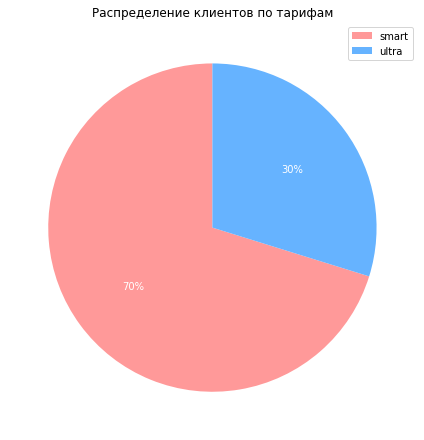

In [37]:
# график распределения пользователей по тарифам
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(users_number, colors = colors, autopct='%1.0f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
plt.tight_layout()
plt.title('Распределение клиентов по тарифам')
plt.legend(users_number.index, loc='upper right')
plt.show()

Распределение клиентов выборки по тарифам: smart — 70 %, ultra — 30 %.

___

In [38]:
# параметры для анализа поведения клиентов оператора
parameters = [['calls_per_month', 'Количество исходящих звонков в месяц', 'Звонки, шт.'],
              ['calls_month_duration_minutes','Продолжительность исходящих звонков в месяц', 'Продолжительность, мин.'],
              ['messages_per_month', 'Количество отправленных сообщений в месяц', 'Сообщения, шт.'],
              ['internet_per_month_mb','Объем интернет-трафика в месяц', 'Объем, Гб']
             ]

# порядок анализа тарифов
tariffs_order = ['smart','ultra']

Параметр: Количество исходящих звонков в месяц


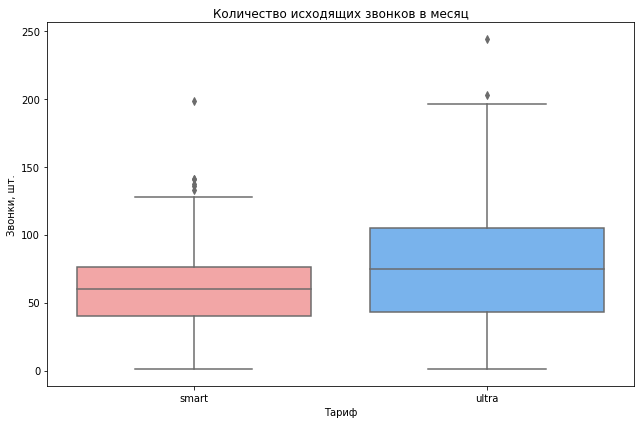

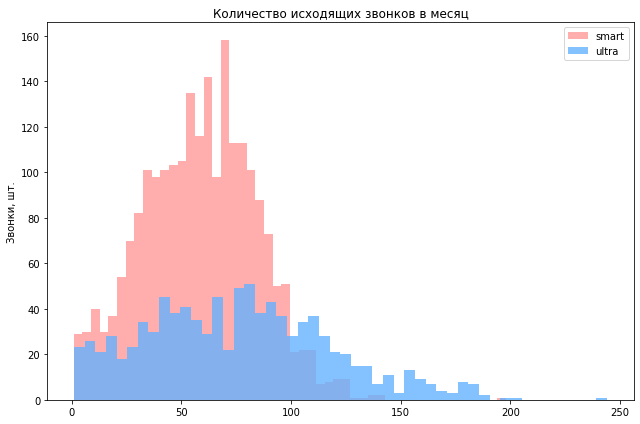


Тариф: "smart"
Параметр: Количество исходящих звонков в месяц

Среднее значение: 58.6
Дисперсия: 665.1
Стандартное отклонение: 25.8

count   2,223.0
mean       58.6
std        25.8
min         1.0
25%        40.0
50%        60.0
75%        76.0
max       198.0
Name: calls_per_month, dtype: float64


Тариф: "ultra"
Параметр: Количество исходящих звонков в месяц

Среднее значение: 76.0
Дисперсия: 1796.2
Стандартное отклонение: 42.4

count   951.0
mean     76.0
std      42.4
min       1.0
25%      43.0
50%      75.0
75%     105.0
max     244.0
Name: calls_per_month, dtype: float64


--------------------


Параметр: Продолжительность исходящих звонков в месяц


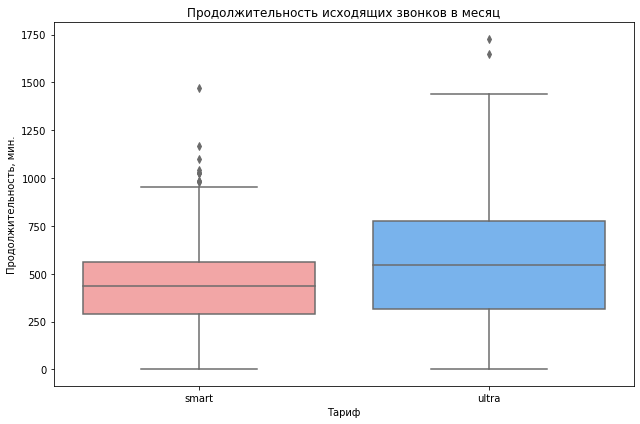

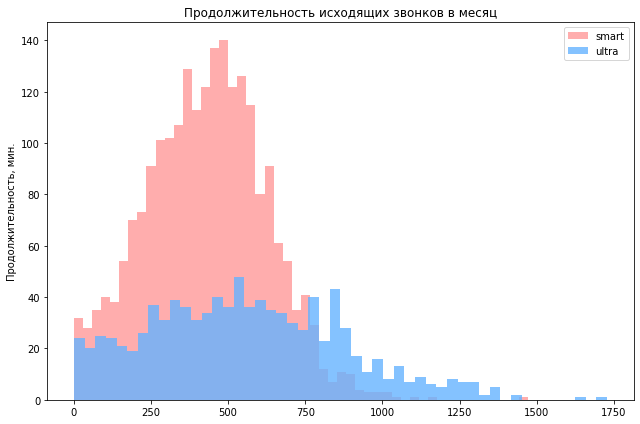


Тариф: "smart"
Параметр: Продолжительность исходящих звонков в месяц

Среднее значение: 430.6
Дисперсия: 37561.1
Стандартное отклонение: 193.8

count   2,223.0
mean      430.6
std       193.9
min         1.0
25%       292.0
50%       435.0
75%       561.0
max     1,471.0
Name: calls_month_duration_minutes, dtype: float64


Тариф: "ultra"
Параметр: Продолжительность исходящих звонков в месяц

Среднее значение: 560.1
Дисперсия: 98958.5
Стандартное отклонение: 314.6

count     951.0
mean      560.1
std       314.7
min         1.0
25%       318.0
50%       544.0
75%       776.5
max     1,727.0
Name: calls_month_duration_minutes, dtype: float64


--------------------


Параметр: Количество отправленных сообщений в месяц


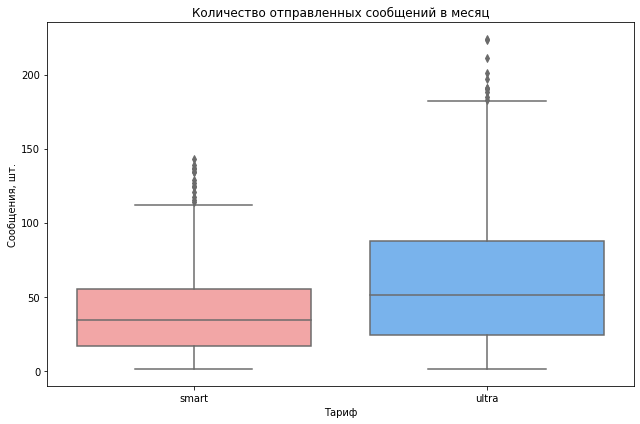

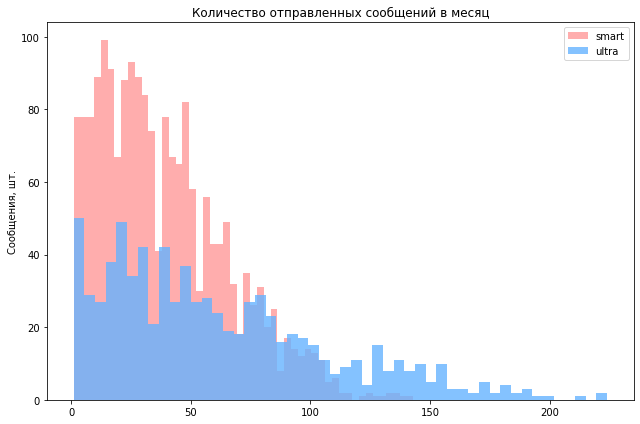


Тариф: "smart"
Параметр: Количество отправленных сообщений в месяц

Среднее значение: 38.7
Дисперсия: 717.2
Стандартное отклонение: 26.8

count   1,922.0
mean       38.7
std        26.8
min         1.0
25%        17.0
50%        34.0
75%        55.0
max       143.0
Name: messages_per_month, dtype: float64


Тариф: "ultra"
Параметр: Количество отправленных сообщений в месяц

Среднее значение: 61.2
Дисперсия: 2107.0
Стандартное отклонение: 45.9

count   795.0
mean     61.2
std      45.9
min       1.0
25%      24.0
50%      51.0
75%      87.5
max     224.0
Name: messages_per_month, dtype: float64


--------------------


Параметр: Объем интернет-трафика в месяц


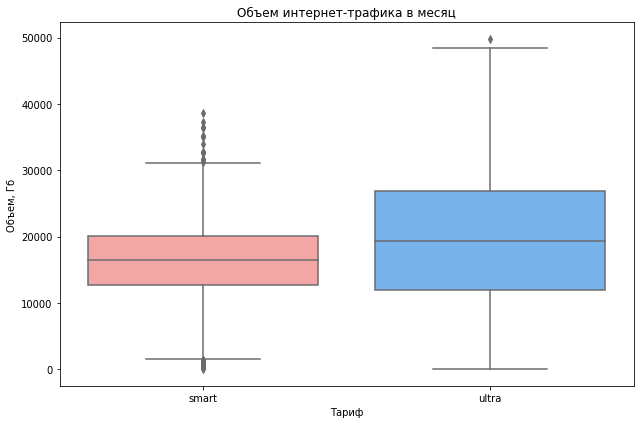

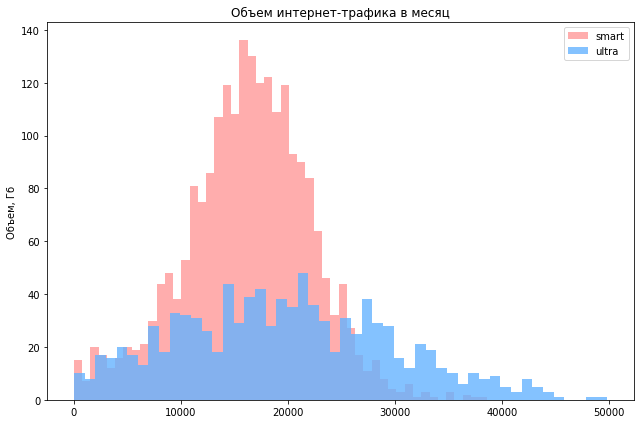


Тариф: "smart"
Параметр: Объем интернет-трафика в месяц

Среднее значение: 16244.5
Дисперсия: 34453604.9
Стандартное отклонение: 5869.7

count    2,228.0
mean    16,244.5
std      5,871.0
min          1.0
25%     12,673.2
50%     16,541.5
75%     20,078.8
max     38,627.0
Name: internet_per_month_mb, dtype: float64


Тариф: "ultra"
Параметр: Объем интернет-трафика в месяц

Среднее значение: 19688.6
Дисперсия: 98957235.8
Стандартное отклонение: 9947.7

count      975.0
mean    19,688.6
std      9,952.8
min          1.0
25%     12,022.0
50%     19,416.0
75%     26,921.5
max     49,793.0
Name: internet_per_month_mb, dtype: float64


--------------------




In [39]:
# анализ поведения клиентов оператора
for parameter in parameters:
    print('Параметр: {}'.format(parameter[1]))

    # построение графика boxplot
    sns.boxplot(x="tariff", 
                y=parameter[0],
                data=report,
                palette=colors,
                order = tariffs_order
               )
    plt.title(parameter[1])
    plt.xlabel('Тариф')
    plt.ylabel(parameter[2])
    plt.tight_layout()
    plt.show()
    print()
    

    # построение гистограмм
    bins = 50
    plt.hist(
        report.query('tariff == "smart"')[parameter[0]],
        bins,
        alpha=0.8,
        label=('smart'),
        color=colors[0]
    )
    plt.hist(
        report.query('tariff == "ultra"')[parameter[0]],
        bins,
        alpha=0.8,
        label=('ultra'),
        color=colors[1]
    )
    plt.title(parameter[1])
    plt.ylabel(parameter[2])
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.show()  
    print()
    
    # расчет среднего количества, дисперсии и стандартного отклонения
    for tariff_temp in tariffs_order:
        print('Тариф: "{}"'.format(tariff_temp))
        print('Параметр: {}'.format(parameter[1]))
        print() 
        

        # среднее 
        mean_temp = np.mean(report.query('tariff == @tariff_temp')[parameter[0]])
        print('Среднее значение: {:.1f}'.format(mean_temp))
        # дисперсия
        variance_temp = np.var(report.query('tariff == @tariff_temp')[parameter[0]])
        print('Дисперсия: {:.1f}'.format(variance_temp))
        # стандартное отклонение
        standard_deviation_temp = np.std(report.query('tariff == @tariff_temp')[parameter[0]])
        print('Стандартное отклонение: {:.1f}'.format(standard_deviation_temp))
        
        
        print()      
        print(report.query('tariff == @tariff_temp')[parameter[0]].describe())
        print()
        print() 
    print('--------------------')
    print()
    print() 

In [40]:
statistics = report.pivot_table(index=['tariff'],
                                values=['calls_per_month',
                                        'calls_month_duration_minutes',
                                        'messages_per_month',
                                        'internet_per_month_mb'],
                                
                                aggfunc={'calls_per_month': [np.mean, np.var, np.std],
                                        'calls_month_duration_minutes': [np.mean, np.var, np.std],
                                        'messages_per_month': [np.mean, np.var, np.std],
                                        'internet_per_month_mb': [np.mean, np.var, np.std]}
                               )
statistics

calls_month_duration_minutes                calls_per_month       \
                               mean   std      var            mean  std   
tariff                                                                    
smart                         430.6 193.9 37,578.0            58.6 25.8   
ultra                         560.1 314.7 99,062.6            76.0 42.4   

               internet_per_month_mb                      messages_per_month  \
           var                  mean     std          var               mean   
tariff                                                                         
smart    665.4              16,244.5 5,871.0 34,469,075.7               38.7   
ultra  1,798.0              19,688.6 9,952.8 99,058,834.6               61.2   

                     
        std     var  
tariff               
smart  26.8   717.6  
ultra  45.9 2,109.7

___

In [41]:
# распределение выручки по тарифам
revenue_total = report.groupby(by='tariff')['revenue'].sum()

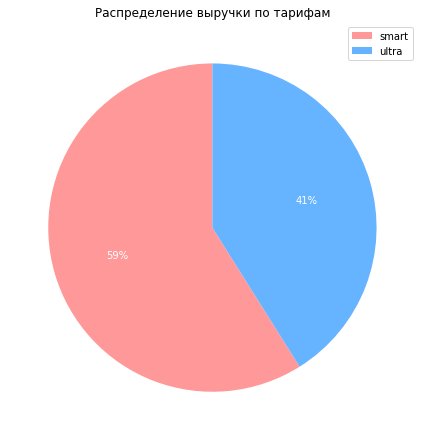

In [42]:
# график распределения выручки по тарифам
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(revenue_total, colors = colors, autopct='%1.0f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
plt.tight_layout()
plt.title('Распределение выручки по тарифам')
plt.legend(revenue_total.index, loc='upper right')
plt.show()

Распределение выручки выборки по тарифам: smart — 57 %, ultra — 43 %.

In [43]:
revenue = report.groupby(by='tariff')[['revenue_calls',
                                       'revenue_messages',
                                       'revenue_internet',
                                       'revenue_month_fee']].sum()
#.reset_index()

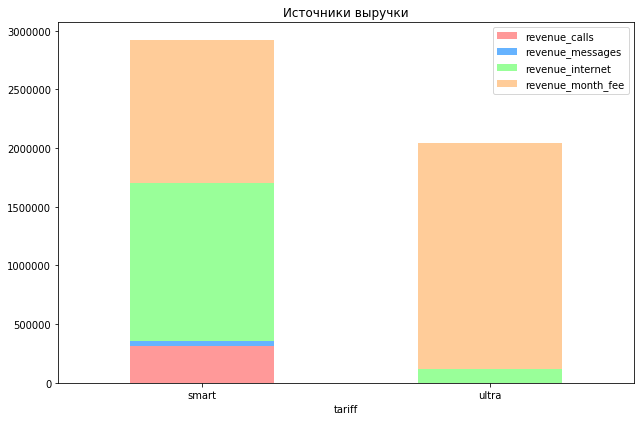

In [44]:
# формирование оси X
xticks=tariffs_order
x=range(len(xticks))

ax = revenue.plot(kind="bar", 
                  colors = colors, 
                  stacked=True
                                          )
plt.tight_layout()
plt.legend(loc='upper right')
plt.title('Источники выручки')

#plt.axis('off')
plt.xticks(x, xticks, rotation = 0)
plt.show()

In [45]:
# доля клиентов, потребляющих услуги сверх пакета
for tariff in tariffs_order:
    extra_count = report.query('tariff == @tariff and (revenue_calls > 0 or revenue_messages > 0 or revenue_internet > 0)')['tariff'].count()
    tariff_count = report.query('tariff == @tariff')['tariff'].count()
    print('Доля клиентов на тарифе {}, потребляющих услуги сверх пакета {:.0%}'. format(tariff, extra_count / tariff_count))

Доля клиентов на тарифе smart, потребляющих услуги сверх пакета 75%
Доля клиентов на тарифе ultra, потребляющих услуги сверх пакета 14%


### Вывод
- Распределение клиентов выборки по тарифам: 
    - smart — 70 %;
    - ultra — 30 %.
- В среднем клиенты на тарифе smart звонят 59 раз в месяц, а на тарифе ultra — 76. 
- Средняя продолжительность звонков на тарифе smart 431 мин. в месяц, а на тарифе ultra — 560.
- В среднем клиенты на тарифе smart отправляют 39 сообщений в месяц, а на тарифе ultra — 61. 
- В среднем клиенты на тарифе smart потребляют 16 Гб в месяц, а на тарифе ultra — 19. 
- Распределение выручки выборки по тарифам:
    - smart — 59 %, 
    - ultra — 41 %.
- Основной объем выручки формируется:
    - на тарифе smart формируется от оплаты интернета сверх пакета и абонентской платы.
    - на тарифе ultra формируется от абонентской платы.

## 4. Проверка гипотез

### Cредняя выручка клиентов по тарифам

Формулировка согласно заданию:  
> Проверьте гипотезы:  
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
___
Так как в задании предлагается сравнить средние значения двух выборок, то необходимо формулировать и проверять гипотезу о равенстве средних двух генеральных совокупностей.

__Нулевая гипотеза:__ средние выручки клиентов тарифов «Ультра» и «Смарт» равны.  
__Альтернативная гипотеза:__ средние выручки клиентов тарифов «Ультра» и «Смарт» отличаются.  
Критический уровень статистической значимости — 1 %. Высокий порог статистической значимости задан с учетом важности и стоимости задачи.

In [46]:
# критический уровень статистической значимости
alpha = .01

results = st.ttest_ind(
    report.query('tariff == "smart"')['revenue'], 
    report.query('tariff == "ultra"')['revenue'], 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.2496710269965528e-233
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью близкой к 100 % средние выручки клиентов тарифов «Ультра» и «Смарт» __не равны__.

In [47]:
# проверка выводов
revenue_stat_general = report.query('revenue > 0').pivot_table(index=['tariff'],
                                values=['revenue_calls',
                                        'revenue_messages',
                                        'revenue_internet',
                                        'revenue'],
                                
                                aggfunc={'revenue_calls': [np.mean, np.var, np.std],
                                        'revenue_messages': [np.mean, np.var, np.std],
                                        'revenue_internet': [np.mean, np.var, np.std],
                                        'revenue': [np.mean, np.var, np.std]}
                               )
revenue_stat_general

revenue                 revenue_calls                revenue_internet  \
          mean   std       var          mean   std      var             mean   
tariff                                                                         
smart  1,312.5 830.9 690,458.2         141.8 272.8 74,394.7            603.3   
ultra  2,071.1 378.8 143,491.2           0.0   0.0      0.0            121.1   

                       revenue_messages               
         std       var             mean  std     var  
tariff                                                
smart  740.5 548,373.2             17.4 40.3 1,626.3  
ultra  378.8 143,491.2              0.0  0.0     0.0

### Cредняя выручка клиентов по городам

Формулировка согласно заданию:  
> Проверьте гипотезы:  
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
___
Так как в задании предлагается сравнить средние значения двух выборок, то необходимо формулировать и проверять гипотезу о равенстве средних двух генеральных совокупностей.

__Нулевая гипотеза:__ средняя выручка клиентов из Москвы и других регионов равны.  
__Альтернативная гипотеза:__ средняя выручка клиентов из Москвы и других регионов отличаются.
Критический уровень статистической значимости — 1 %. Высокий порог статистической значимости задан с учетом важности и стоимости задачи.

In [48]:
# критический уровень статистической значимости
alpha = .01

results = st.ttest_ind(
    report.query('region == "Москва"')['revenue'], 
    report.query('region != "Москва"')['revenue'], 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.560259602740345
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью 56 % средние выручки клиентов из Москвы и других регионов __равны__.

In [49]:
# проверка выводов
revenue_stat_region = report.query('revenue > 0').pivot_table(index=['region'],
                                values=['revenue_calls',
                                        'revenue_messages',
                                        'revenue_internet',
                                        'revenue'],
                                
                                aggfunc={'revenue_calls': [np.mean, np.var, np.std],
                                        'revenue_messages': [np.mean, np.var, np.std],
                                        'revenue_internet': [np.mean, np.var, np.std],
                                        'revenue': [np.mean, np.var, np.std]}
                               )
revenue_stat_region

revenue                 revenue_calls                 \
             mean   std       var          mean   std      var   
region                                                           
Москва    1,561.2 753.2 567,332.1          84.5 208.7 43,545.2   
не-Москва 1,541.2 814.5 663,465.7         101.6 242.3 58,716.2   

          revenue_internet                 revenue_messages               
                      mean   std       var             mean  std     var  
region                                                                    
Москва               403.6 627.6 393,847.7              7.5 25.9   668.7  
не-Москва            467.7 701.3 491,761.6             13.1 36.2 1,309.3

### Вывод
- Нулевая гипотеза (средние выручки клиентов тарифов «Ультра» и «Смарт» равны) отвергнута. Верна альтернативная гипотеза — средние выручки клиентов тарифов «Ультра» и «Смарт» отличаются с вероятностью почти более 99 %.
- Нулевая гипотеза (средняя выручка клиентов из Москвы и других регионов равны) верна с вероятностью почти 56 %.  

## 5. Общий вывод

__Наиболее перспективный тариф — «Смарт»:__  
- От тарифа «Смарт» формируется __59 % выручки.__
- Средняя выручка от тарифа «Смарт» __1 313 руб./мес. с клиента__.
- Тарифом «Смарт» пользуются __70 % клиентов.__
- На тарифе «Смарт» __75 % клиентов__ потребляют услуги сверх пакета. 
- Потребление услуг сверх пакета формирует __54 % выручки__ на тарифе «Смарт».
- Сверх пакета на тарифе «Смарт» потребляются все услуги. 46 % выручки на тарифе приносит интернет и 10 % — звонки.

Тариф «Ультра» менее перспективный:
- От тарифа «Ультра» формируется 41 % выручки. 
- Средняя выручка от тарифа «Ультра» 2 071 руб./мес. с клиента.
- Тарифом «Ультра» пользуются 30 % клиентов.
- Только 14 % клиентов на тарифе «Ультра» потребляет услуги сверх пакета 14 % (только интернет) и это формирует всего 5 % выручки от тарифа.  



Средние выручки от тарифов отличаются с вероятностью (p-value) около <99,99 %.
   
Средние выручки по городам почти равны с вероятностью (p-value) около 56 %:
- Москва 1 561 руб./мес. с клиента,
- не-Москва 1 541 руб./мес. с клиента.     
___
- Количественные показатели:
    - Количество звонков, шт./мес.:
        - «Смарт» — 59,
        - «Ультра» — 76. 
    - Средняя продолжительность звонков, мин. в месяц:
        - «Смарт» — 431, 
        - «Ультра» — 560.
    - Отправленные сообщения, шт./мес.:
        - «Смарт» — 39,
        - «Ультра» — 61. 
    - Потребление интернет-трафика, Гб/мес.:
        - «Смарт» — 16,
        - «Ультра» — 19. 